### Bài toán 1: Regression cho tập data Auto_MPG_data.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
# Cài đặt giá trị ngẫu nhiên cố định
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [3]:
# Cài đặt thiết bị tính toán
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [4]:
# Đọc bộ dữ liệu
dataset_path = './data/Auto_MPG_data.csv'
dataset = pd.read_csv(dataset_path)
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


In [5]:
# Tiền xử lý dữ liệu
X = dataset.drop(columns='MPG').values
y = dataset['MPG'].values

In [6]:
# Chia bộ dữ liệu thành train, validation, test (7:2:1)
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

In [7]:
# Chuẩn hóa đặc trưng đầu vào
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [8]:
# Xây dựng DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [9]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [32]:
# Xây dựng mạng MLP
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super().__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.linear2 = nn.Linear(hidden_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = self.linear1(x)
        x = F.tanh(x)
        x = self.linear2(x)
        x = F.tanh(x)
        out = self.output(x)
        return out.squeeze(1)

In [27]:
input_dims = X_train.shape[1]
output_dims = 1
hidden_dims = 64

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

In [28]:
# Khai báo hàm loss và optimizer
lr = 1e-2
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [29]:
# Hàm tính điểm R2
def r_squared(y_true, y_pred):
    y_true = torch.Tensor(y_true).to(device)
    y_pred = torch.Tensor(y_pred).to(device)
    mean_true = torch.mean(y_true)
    ss_tot = torch.sum((y_true - mean_true) ** 2)
    ss_res = torch.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2

In [33]:
# Huấn luyện mô hình
epochs = 100
train_losses = []
val_losses = []
train_r2 = []
val_r2 = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    val_target = []
    train_predict = []
    val_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        train_predict += outputs.tolist()
        train_target += y_samples.tolist()
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_r2.append(r_squared(train_target, train_predict))
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict += outputs.tolist()
            val_target += y_samples.tolist()
            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_r2.append(r_squared(val_target, val_predict))
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 8.028	Validation loss: 5.315

EPOCH 2:	Training loss: 7.790	Validation loss: 5.009

EPOCH 3:	Training loss: 7.849	Validation loss: 4.972

EPOCH 4:	Training loss: 8.351	Validation loss: 4.903

EPOCH 5:	Training loss: 8.275	Validation loss: 5.814

EPOCH 6:	Training loss: 8.237	Validation loss: 5.145

EPOCH 7:	Training loss: 8.345	Validation loss: 4.731

EPOCH 8:	Training loss: 8.624	Validation loss: 14.075

EPOCH 9:	Training loss: 8.652	Validation loss: 5.344

EPOCH 10:	Training loss: 8.143	Validation loss: 6.470

EPOCH 11:	Training loss: 7.826	Validation loss: 5.032

EPOCH 12:	Training loss: 7.918	Validation loss: 4.975

EPOCH 13:	Training loss: 8.695	Validation loss: 5.057

EPOCH 14:	Training loss: 7.607	Validation loss: 4.761

EPOCH 15:	Training loss: 8.672	Validation loss: 7.950

EPOCH 16:	Training loss: 8.583	Validation loss: 4.632

EPOCH 17:	Training loss: 7.832	Validation loss: 4.767

EPOCH 18:	Training loss: 7.765	Validation loss: 4.990

EPOCH 19:	Trainin

In [34]:
# Đánh giá mô hình
model.eval()
with torch.no_grad():
    y_hat = model(X_test)
    test_set_r2 = r_squared(y_hat, y_test)
    print('Evaluation on test set:')
    print(f'R2: {test_set_r2}')

Evaluation on test set:
R2: 0.879885196685791


### Bài toán 2: Task về classification tập data NonLinear_data.npy

In [35]:
# Tải các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [36]:
# Cài đặt giá trị ngẫu nhiên cố định và thiết bị tính toán
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [37]:
# Đọc dữ liệu
data_path = './data/NonLinear_data.npy'
data = np.load(data_path, allow_pickle=True).item()
X, y = data['X'], data['labels']
X.shape, y.shape


((300, 2), (300,))

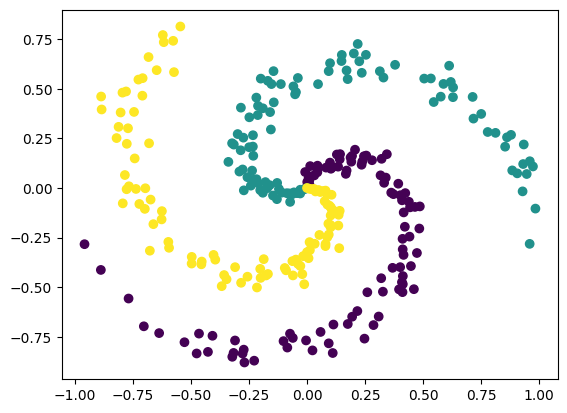

In [38]:
#plot data
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis')
plt.show()


In [39]:
# Chia dữ liệu thành train, val, test
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=val_size, random_state=random_state, shuffle=is_shuffle)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=test_size, random_state=random_state, shuffle=is_shuffle)

In [40]:
# Chuẩn hóa dữ liệu đầu vào
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

In [41]:
# Xây dựng DataLoader
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [104]:
# Xây dựng mạng MLP
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh(x)
        out = self.output(x)
        return out.squeeze(1)

In [105]:
input_dims = X_train.shape[1]
output_dims = len(torch.unique(y_train))
hidden_dims = 512

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)


In [106]:
# Khai báo hàm loss và optimizer
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [107]:
# Hàm tính độ chính xác
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [108]:
# Train mô hình
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')


EPOCH 1:	Training loss: 0.897	Validation loss: 0.909

EPOCH 2:	Training loss: 0.779	Validation loss: 0.929

EPOCH 3:	Training loss: 0.761	Validation loss: 0.818

EPOCH 4:	Training loss: 0.734	Validation loss: 1.264

EPOCH 5:	Training loss: 0.791	Validation loss: 0.821

EPOCH 6:	Training loss: 0.733	Validation loss: 0.872

EPOCH 7:	Training loss: 0.657	Validation loss: 0.777

EPOCH 8:	Training loss: 0.641	Validation loss: 0.995

EPOCH 9:	Training loss: 0.830	Validation loss: 0.884

EPOCH 10:	Training loss: 0.710	Validation loss: 0.979

EPOCH 11:	Training loss: 0.698	Validation loss: 0.778

EPOCH 12:	Training loss: 0.661	Validation loss: 0.790

EPOCH 13:	Training loss: 0.583	Validation loss: 0.805

EPOCH 14:	Training loss: 0.589	Validation loss: 0.798

EPOCH 15:	Training loss: 0.652	Validation loss: 0.792

EPOCH 16:	Training loss: 0.668	Validation loss: 0.684

EPOCH 17:	Training loss: 0.560	Validation loss: 0.603

EPOCH 18:	Training loss: 0.553	Validation loss: 0.613

EPOCH 19:	Training

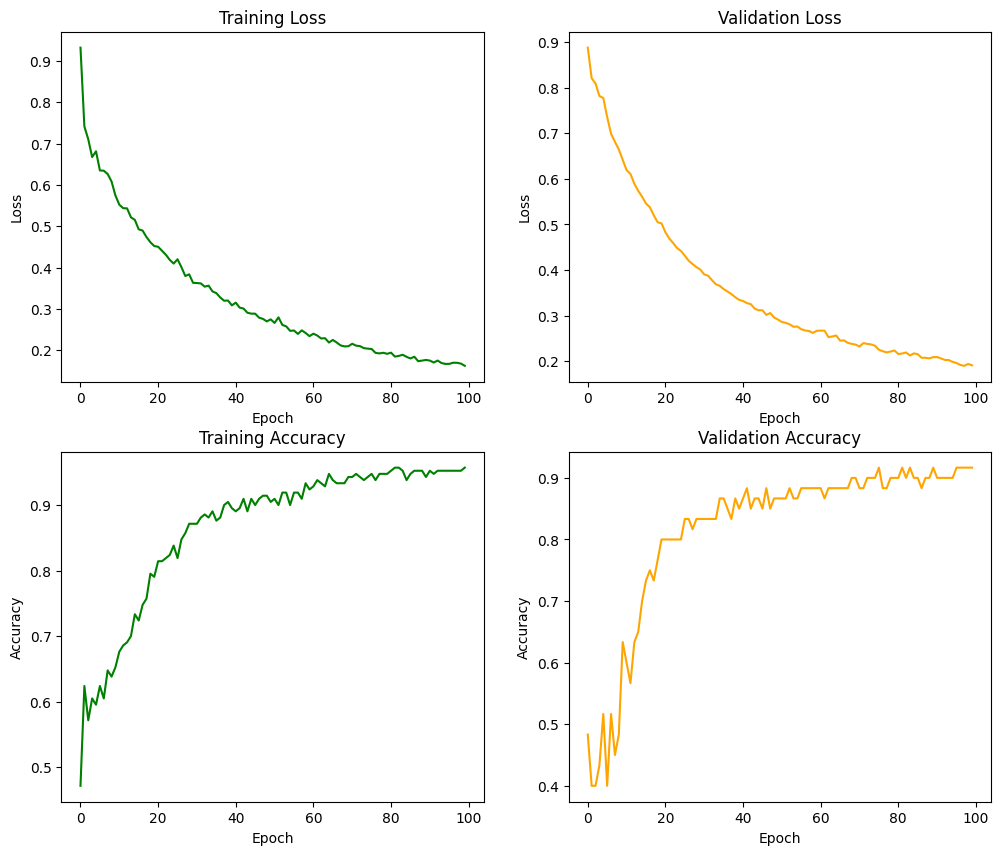

In [75]:
# Vẽ đồ thị
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')
ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')
ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')
ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')
plt.show()

In [109]:
# Đánh giá mô hình
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.9


### Bài toán 3: Task về classification ảnh.


In [5]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Resize
from torchvision.io import read_image
from sklearn.model_selection import train_test_split


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [7]:
# Đọc và xử lý dữ liệu từ các thư mục
train_dir = './data/train'
test_dir = './data/test'

In [8]:
# Lấy danh sách các class
classes = os.listdir(train_dir)
label2idx = {cls: idx for idx, cls in enumerate(classes)}
idx2label = {idx: cls for cls, idx in label2idx.items()}
label2idx, idx2label

({'surprise': 0,
  'angry': 1,
  'disgust': 2,
  'happy': 3,
  'neutral': 4,
  'fear': 5,
  'sad': 6},
 {0: 'surprise',
  1: 'angry',
  2: 'disgust',
  3: 'happy',
  4: 'neutral',
  5: 'fear',
  6: 'sad'})

In [9]:
img_height, img_width = 128, 128  # Kích thước ảnh sau khi resize

class ImageDataset(Dataset):
    def __init__(self, img_dir, norm, label2idx, split='train', train_ratio=0.8):
        self.resize = Resize((img_height, img_width))
        self.norm = norm
        self.split = split
        self.train_ratio = train_ratio
        self.img_dir = img_dir
        self.label2idx = label2idx
        self.img_paths, self.img_labels = self.read_img_files()

        if split in ['train', 'val'] and 'train' in img_dir.lower():
            train_data, val_data = train_test_split(
                list(zip(self.img_paths, self.img_labels)),
                train_size=train_ratio,
                random_state=random_state,
                stratify=self.img_labels
            )
            if split == 'train':
                self.img_paths, self.img_labels = zip(*train_data)
            elif split == 'val':
                self.img_paths, self.img_labels = zip(*val_data)

    def read_img_files(self):
        img_paths = []
        img_labels = []
        for cls in self.label2idx.keys():
            for img in os.listdir(os.path.join(self.img_dir, cls)):
                img_paths.append(os.path.join(self.img_dir, cls, img))
                img_labels.append(cls)
        return img_paths, img_labels

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        cls = self.img_labels[idx]
        img = self.resize(read_image(img_path))
        img = img.type(torch.float32)
        label = self.label2idx[cls]
        if self.norm:
            img = (img / 127.5) - 1  # Chuẩn hóa ảnh vào [-1, 1]
        return img, label

In [10]:
# Tạo DataLoader cho tập train, val và test
batch_size = 256
train_dataset = ImageDataset(train_dir, True, label2idx, split='train')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = ImageDataset(train_dir, True, label2idx, split='val')
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = ImageDataset(test_dir, True, label2idx, split='test')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

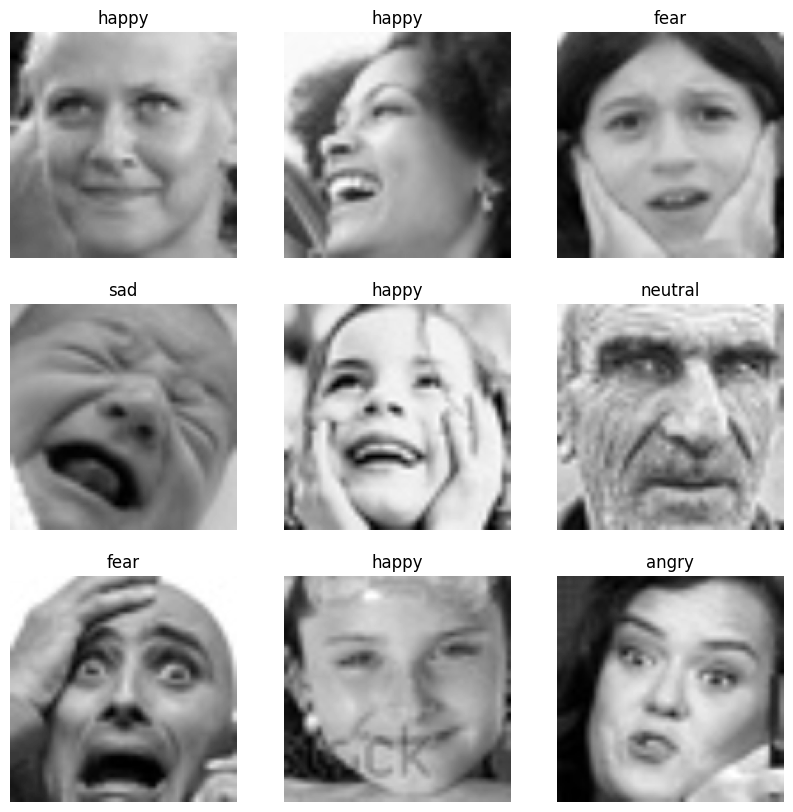

In [11]:
# Hiển thị một số ảnh mẫu
image_batch, label_batch = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    minv = image_batch[i].numpy().min()
    maxv = image_batch[i].numpy().max()
    plt.imshow(np.squeeze(image_batch[i].numpy()), vmin=minv, vmax=maxv, cmap="gray")
    label = label_batch[i]
    plt.title(idx2label[label.item()])
    plt.axis("off")
plt.show()

In [12]:
# Xây dựng mạng MLP cho phân loại ảnh
class MLP(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims * 4)
        self.linear2 = nn.Linear(hidden_dims * 4, hidden_dims * 2)
        self.linear3 = nn.Linear(hidden_dims * 2, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)

    def forward(self, x):
        x = nn.Flatten()(x)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        x = F.relu(x)
        x = self.linear3(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [13]:
input_dims = img_height * img_width
output_dims = len(classes)
hidden_dims = 64
lr = 1e-2

model = MLP(input_dims=input_dims, hidden_dims=hidden_dims, output_dims=output_dims).to(device)

In [14]:
# Khai báo hàm loss và optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [15]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim=1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len(y_true)
    return accuracy

In [16]:
epochs = 40
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []
    model.train()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    train_predict = torch.cat(train_predict)
    train_target = torch.cat(train_target)
    train_acc = compute_accuracy(train_predict, train_target)
    train_accs.append(train_acc)
    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader:
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_loss += criterion(outputs, y_samples).item()
            val_predict.append(outputs.cpu())
            val_target.append(y_samples.cpu())
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        val_predict = torch.cat(val_predict)
        val_target = torch.cat(val_target)
        val_acc = compute_accuracy(val_predict, val_target)
        val_accs.append(val_acc)
    print(f'\nEPOCH {epoch + 1}:\tTraining loss: {train_loss:.3f}\tValidation loss: {val_loss:.3f}')



EPOCH 1:	Training loss: 1.932	Validation loss: 1.905

EPOCH 2:	Training loss: 1.878	Validation loss: 1.851

EPOCH 3:	Training loss: 1.828	Validation loss: 1.811

EPOCH 4:	Training loss: 1.794	Validation loss: 1.786

EPOCH 5:	Training loss: 1.770	Validation loss: 1.766

EPOCH 6:	Training loss: 1.750	Validation loss: 1.747

EPOCH 7:	Training loss: 1.728	Validation loss: 1.725

EPOCH 8:	Training loss: 1.705	Validation loss: 1.704

EPOCH 9:	Training loss: 1.684	Validation loss: 1.689

EPOCH 10:	Training loss: 1.667	Validation loss: 1.674

EPOCH 11:	Training loss: 1.652	Validation loss: 1.662

EPOCH 12:	Training loss: 1.640	Validation loss: 1.652

EPOCH 13:	Training loss: 1.629	Validation loss: 1.647

EPOCH 14:	Training loss: 1.619	Validation loss: 1.640

EPOCH 15:	Training loss: 1.610	Validation loss: 1.632

EPOCH 16:	Training loss: 1.601	Validation loss: 1.627

EPOCH 17:	Training loss: 1.593	Validation loss: 1.623

EPOCH 18:	Training loss: 1.585	Validation loss: 1.615

EPOCH 19:	Training

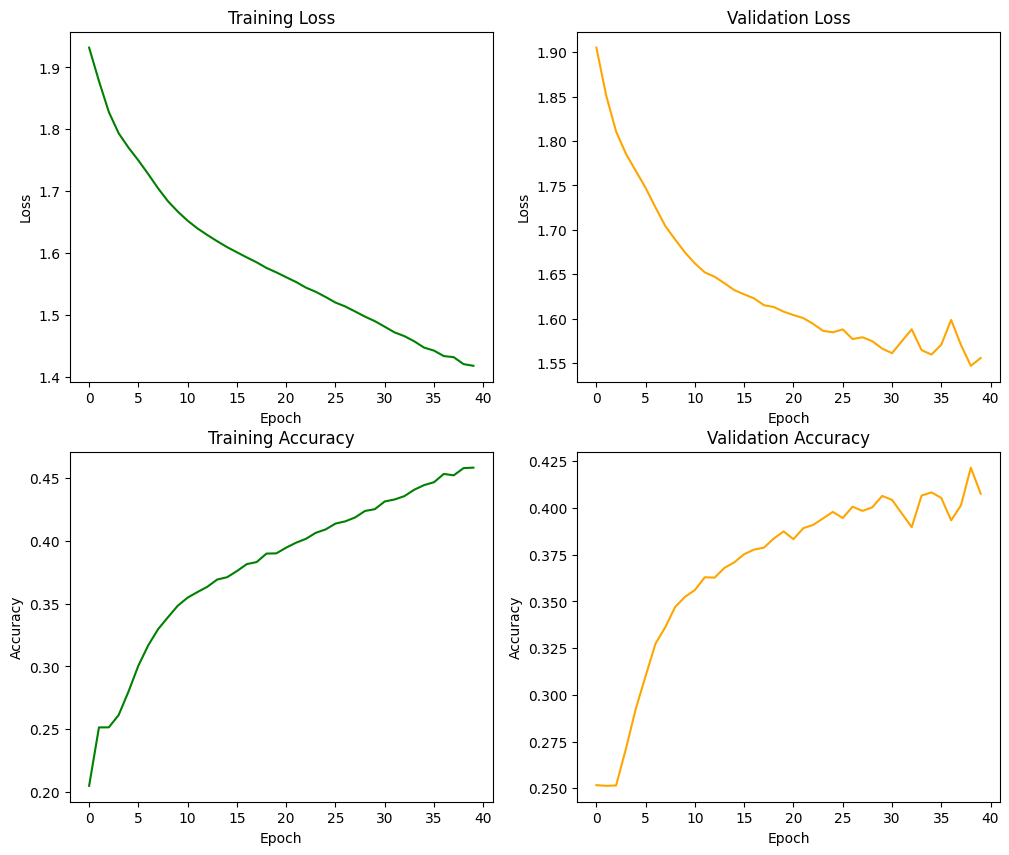

In [18]:
# Vẽ đồ thị
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')
plt.show()

In [17]:
# Đánh giá mô hình
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)
        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())
    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

print('Evaluation on test set:')
print(f'Accuracy: {test_acc}')

Evaluation on test set:
Accuracy: 0.414182223460574
